# Kalman Filter
> Implementation of Kalman filters using pytorch and parameter optimizations with gradient descend

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp kalman.filter

In [ ]:
#| export
from fastcore.test import *
from fastcore.basics import patch
from meteo_imp.utils import *
from meteo_imp.data_preparation import MeteoDataTest
import pykalman
from typing import *

import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import MultivariateNormal

## Introduction

## Utils

In [ ]:
#| exporti
def array1d(X):
    """Returns at least 1-d array with data from X"""
    return torch.atleast_1d(torch.as_tensor(X))

def array2d(X):
    """Returns at least 2-d array with data from X"""
    return torch.atleast_2d(torch.as_tensor(X))


In [ ]:
#| export
def _determine_dimensionality(variables, default):
    """Derive the dimensionality of the state space

    Parameters
    ----------
    variables : list of ({None, array}, conversion function, index)
        variables, functions to convert them to arrays, and indices in those
        arrays to derive dimensionality from.
        
    Returns
    -------
    dim : int
        dimensionality of state space as derived from variables or default.
    """
    # gather possible values based on the variables
    candidates = []
    for (v, converter, idx) in variables:
        if v is not None:
            v = converter(v)
            candidates.append(v.shape[idx])
    
     # also use the manually specified default
    if default is not None:
        candidates.append(default)
    
    # ensure consistency of all derived values
    if len(candidates) == 0:
        return 1
    else:
        if not torch.all(torch.tensor(candidates) == candidates[0]):
            raise ValueError(
                "The shape of all " +
                "parameters is not consistent.  " +
                "Please re-check their values."
            )
        return candidates[0]


def _last_dims(X: Tensor, t: int, ndims: int=2):
    """Extract the final dimensions of `X`

    Extract the final `ndim` dimensions at index `t` if `X` has >= `ndim` + 1
    dimensions, otherwise return `X`.

    Parameters
    ----------
    X : Tensor with at least dimension `ndims`
    t : int
        index to use for the `ndims` + 1th dimension
    ndims : int, optional
        number of dimensions in the array desired

    Returns
    -------
    Y : array with dimension `ndims`
        the final `ndims` dimensions indexed by `t`
    """
    if len(X.shape) == ndims + 1:
        return X[t]
    elif len(X.shape) == ndims:
        return X
    else:
        raise ValueError(("X only has %d dimensions when %d" +
                " or more are required") % (len(X.shape), ndims))

In [ ]:
#| export
def _stack_detach(l: Collection[Tensor]):
    return torch.stack(list(map(lambda x: x.detach(), l)))

### Positive Definite Constraint

transform any matrix $A$ into a positive definite matrix ($PD$) using the following formula

$PD = A A^T + aI$

where $AA^T$ ensures that A is positive semi-definite and adding a small positive number of the diagonal $aI$ ensures that is definite 

for details see https://stackoverflow.com/a/58192215/8555045

add also inverse transformation using cholesky decomposition


API inspired by gpytorch constraints

In [ ]:
#| export
class PosDef():
    """ Positive Definite Constraint for PyTorch parameters"""
    def __init__(self, a=1e-7):
        self.a = a
    def transform(self,
                  raw # square matrix that will be 
                 ):
        "transform any square matrix into a positive definite one"
        return raw @ raw.T + (self.a * torch.eye(raw.shape[0]))
    
    def inverse_transform(self,
                          value # a positive definite matrix
                         ):
        "tranform positive definite matrix into a raw matrix"
        return torch.linalg.cholesky(value)

In [ ]:
A = torch.rand(3,3)
constraint = PosDef()

pd = constraint.transform(A)

In [ ]:
pd

tensor([[0.9447, 1.0227, 0.6465],
        [1.0227, 1.2100, 0.7608],
        [0.6465, 0.7608, 0.4902]])

In [ ]:
test_eq(torch.distributions.constraints.positive_definite.check(pd), True)

In [ ]:
constraint.inverse_transform(pd)

tensor([[0.9720, 0.0000, 0.0000],
        [1.0522, 0.3208, 0.0000],
        [0.6652, 0.1898, 0.1083]])

In [ ]:
test_close(pd, constraint.transform(constraint.inverse_transform(pd)))

In [ ]:
#| export
def check_posdef(cov):
    if not torch.distributions.constraints.positive_definite.check(cov).item(): 
        raise ValueError(f"expected positive definite matrix. \n{cov}")

## KalmanFilter

The Kalman Filter is an algorithm designed to estimate $P(x_t | y_{0:t})$.  As all state transitions and obss are linear with Gaussian distributed noise, these distributions can be represented exactly as Gaussian distributions with mean `filt_state_means[t]` and covs `filt_state_covs[t]`.
Similarly, the Kalman Smoother is an algorithm designed to estimate $P(x_t | y_{0:T-1})$



In [ ]:
#| export
class KalmanFilter(torch.nn.Module):
    """Kalman Filter and Kalman Smoother using PyTorch"""
    def __init__(self,
            transition_matrices: Tensor=None, # [n_timesteps-1, n_dim_state, n_dim_state] or [n_dim_state,n_dim_state] 
               # Also known as $A$ 
               # state transition matrix between times t and t+1 for t in [0...n_timesteps-2]
            obs_matrices: Tensor=None, # [n_timesteps, n_dim_obs, n_dim_state] or [n_dim_obs, n_dim_state]
                # Also known as $H$
                # obs matrix for times [0...n_timesteps-1]
            transition_cov: Tensor=None, # [n_dim_state, n_dim_state] 
                 # Also known as $Q$
                 # state transition cov matrix for times [0...n_timesteps-2]
            obs_cov: Tensor=None, # [n_dim_obs, n_dim_obs]
                 # Also known as $R$
                 # obs cov matrix for times [0...n_timesteps-1]
            transition_offsets: Tensor=None, # [n_timesteps-1, n_dim_state] or [n_dim_state]
                 # Also known as $b$
                 # state offsets for times [0...n_timesteps-2]
            obs_offsets: Tensor=None, # [n_timesteps, n_dim_obs] or [n_dim_obs]
                 # Also known as $d$
            initial_state_mean: Tensor=None, # [n_dim_state]
                 # Also known as $\mu_0"$
            initial_state_cov: Tensor=None, # [n_dim_state, n_dim_state]
                 # Also known as $\Sigma_0$
            n_dim_state: int = None, # Number of dimensions for state - defaults to 1 if cannot be infered from parameters
            n_dim_obs: int = None # Number of dimensions for observations - defaults to 1 if cannot be infered from parameters
                ):
        """Initialize Kalman Filter"""
        
        super().__init__()
        
        # determine size of state space and check parameters are consistent
        n_dim_state = _determine_dimensionality(
            [(transition_matrices, array2d, -2),
             (transition_offsets, array1d, -1),
             (transition_cov, array2d, -2),
             (initial_state_mean, array1d, -1),
             (initial_state_cov, array2d, -2),
             (obs_matrices, array2d, -1)],
            n_dim_state
        )
        n_dim_obs = _determine_dimensionality(
            [(obs_matrices, array2d, -2),
             (obs_offsets, array1d, -1),
             (obs_cov, array2d, -2)],
            n_dim_obs
        )
        
        self.n_dim_obs = n_dim_obs
        self.n_dim_state = n_dim_state
        
        params = {
        # name                 value         default_value                              converter constraint
        'transition_matrices': [transition_matrices, torch.eye(n_dim_state),            array2d, None    ],
        'transition_offsets':  [transition_offsets,  torch.zeros(n_dim_state),          array1d, None    ],
        'transition_cov':      [transition_cov,      torch.eye(n_dim_state),            array2d, PosDef()],
        'obs_matrices':        [obs_matrices,        torch.eye(n_dim_obs, n_dim_state), array2d, None    ],
        'obs_offsets':         [obs_offsets,         torch.zeros(n_dim_obs),            array1d, None    ],
        'obs_cov':             [obs_cov,             torch.eye(n_dim_obs),              array2d, PosDef()],
        'initial_state_mean':  [initial_state_mean,  torch.zeros(n_dim_state),          array1d, None    ],
        'initial_state_cov':   [initial_state_cov,   torch.eye(n_dim_state),            array2d, PosDef()],
        }
        
        self._init_params(params)
        
    def _init_params(self, params):
        for name, (value, default, converter, constraint) in params.items():
            value = value if value is not None else default
            value = converter(value) 
            if constraint is not None:
                name, value = self._init_constraint(name, value, constraint)
            self._init_param(name, value)    
    
    def _init_param(self, param_name, value):
        self.register_parameter(param_name, torch.nn.Parameter(value))
    
    ## Constraints ----
    def _init_constraint(self, param_name, value, constraint):
        name = param_name + "_raw"
        value = constraint.inverse_transform(value)
        setattr(self, param_name + "_constraint", constraint)
        return name, value
    
    def _get_constraint(self, param_name):
        constraint = getattr(self, param_name + "_constraint")
        raw_value = getattr(self, param_name + "_raw")
        return constraint.transform(raw_value)
    
    def _set_constraint(self, param_name, value):
        constraint = getattr(self, param_name + "_constraint")
        raw_value = constraint.inverse_transform(value)
        self._init_param(param_name + "_raw", raw_value)
        

    
    ### convenience functions to get and set parameters that have a constraint
    
    @property
    def transition_cov(self):
        return self._get_constraint('transition_cov')
    
    @transition_cov.setter
    def transition_cov(self, value):
        return self._set_constraint('transition_cov', value)
    
    @property
    def obs_cov(self):
        return self._get_constraint('obs_cov')
    
    @obs_cov.setter
    def obs_cov(self, value):
        return self._set_constraint('obs_cov', value)
    
    @property
    def initial_state_cov(self):
        return self._get_constraint('initial_state_cov')
    
    @initial_state_cov.setter
    def initial_state_cov(self, value):
        return self._set_constraint('initial_state_cov', value)
    
    
    ### -----
    
    def _parse_obs(self, obs, mask=None):
        """Safely convert observations to their expected format"""
        obs = torch.atleast_2d(obs)
        if obs.shape[0] == 1 and obs.shape[1] > 1:
            obs = obs.T
        if mask is None: mask = ~torch.isnan(obs).any(axis=1)
        return obs, mask
    
    def __repr__(self):
        return f"""Kalman Filter
        N dim obs: {self.n_dim_obs}, N dim state: {self.n_dim_state}"""

In [ ]:
k = KalmanFilter()

In [ ]:
k.obs_cov

tensor([[1.0000]], grad_fn=<AddBackward0>)

In [ ]:
k.initial_state_cov

tensor([[1.0000]], grad_fn=<AddBackward0>)

In [ ]:
k.initial_state_cov = array2d(torch.tensor(3.))

In [ ]:
k.initial_state_cov

tensor([[3.]], grad_fn=<AddBackward0>)

In [ ]:
k.initial_state_cov_raw

Parameter containing:
tensor([[1.7321]], requires_grad=True)

In [ ]:
list(k.named_parameters())

[('transition_matrices',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('transition_offsets',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('transition_cov_raw',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('obs_matrices',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('obs_offsets',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('obs_cov_raw',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('initial_state_mean',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('initial_state_cov_raw',
  Parameter containing:
  tensor([[1.7321]], requires_grad=True))]

In [ ]:
k = KalmanFilter()
# pykalman reference implementation
pyk = pykalman.KalmanFilter()

In [ ]:
X = torch.tensor([1,2,3])
nX = X.numpy()
X

tensor([1, 2, 3])

2 dimensional dobs

In [ ]:
X2 = torch.tensor([[i, 10. * i] for i in range(1,5)])
nX2 = X2.numpy()

In [ ]:
k2 = KalmanFilter(transition_matrices = torch.eye(2), obs_matrices=torch.eye(2))

pyk2 = pykalman.KalmanFilter(n_dim_obs = 2, n_dim_state=2)

In [ ]:
X2

tensor([[ 1., 10.],
        [ 2., 20.],
        [ 3., 30.],
        [ 4., 40.]])

In [ ]:
obs_mask = torch.ones_like(X2, dtype=torch.bool)
obs_mask[0, 1] = False # only one value missing
obs_mask[2, :] = False # whole row missing
# Xm X missing
X2m = X2.clone()
X2m[~obs_mask] = torch.nan
# nXm Numpy X missing
nX2m = np.ma.masked_array(X2.numpy(), mask = ~obs_mask.numpy())

In [ ]:
obs_mask

tensor([[ True, False],
        [ True,  True],
        [False, False],
        [ True,  True]])

In [ ]:
X2m

tensor([[ 1., nan],
        [ 2., 20.],
        [nan, nan],
        [ 4., 40.]])

In [ ]:
nX2m

masked_array(
  data=[[1.0, --],
        [2.0, 20.0],
        [--, --],
        [4.0, 40.0]],
  mask=[[False,  True],
        [False, False],
        [ True,  True],
        [False, False]],
  fill_value=1e+20,
  dtype=float32)

### Filter

#### Filter predict

In [ ]:
#| export
def _filter_predict(transition_matrix, transition_cov,
                    transition_offset, current_state_mean,
                    current_state_cov):
    r"""Calculate the mean and cov of :math:`P(x_{t+1} | z_{0:t})`

    Using the mean and cov of :math:`P(x_t | z_{0:t})`, calculate the
    mean and cov of :math:`P(x_{t+1} | z_{0:t})`.

    Parameters
    ----------
    transition_matrix : [n_dim_state, n_dim_state} array
        state transition matrix from time t to t+1
    transition_cov : [n_dim_state, n_dim_state] array
        cov matrix for state transition from time t to t+1
    transition_offset : [n_dim_state] array
        offset for state transition from time t to t+1
    current_state_mean: [n_dim_state] array
        mean of state at time t given obss from times
        [0...t]
    current_state_cov: [n_dim_state, n_dim_state] array
        cov of state at time t given obss from times
        [0...t]

    Returns
    -------
    pred_state_mean : [n_dim_state] array
        mean of state at time t+1 given obss from times [0...t]
    pred_state_cov : [n_dim_state, n_dim_state] array
        cov of state at time t+1 given obss from times
        [0...t]
    """
    pred_state_mean = transition_matrix @ current_state_mean + transition_offset
    pred_state_cov =  transition_matrix @ current_state_cov @ transition_matrix + transition_cov

    check_posdef(pred_state_cov)
    
    return (pred_state_mean, pred_state_cov)

In [ ]:
trans_m = np.eye(2)
trans_cov = np.eye(2)
trans_off = np.zeros((2,2))
curr_mean = np.ones((2,1))
curr_cov = np.zeros((2,2))

In [ ]:
_filter_predict(torch.tensor(trans_m) , torch.tensor(trans_cov), torch.tensor(trans_off), torch.tensor(curr_mean), torch.tensor(curr_cov))

(tensor([[1., 1.],
         [1., 1.]], dtype=torch.float64),
 tensor([[1., 0.],
         [0., 1.]], dtype=torch.float64))

In [ ]:
test_close(
    pykalman.standard._filter_predict(trans_m , trans_cov, trans_off, curr_mean, curr_cov),
    _filter_predict(torch.tensor(trans_m) , torch.tensor(trans_cov), torch.tensor(trans_off), torch.tensor(curr_mean), torch.tensor(curr_cov)))

#### Filter correct

In [ ]:
#| export
def _filter_correct(obs_matrix, obs_cov,
                    obs_offset, pred_state_mean,
                    pred_state_cov, obs, mask):
    r"""Correct a pred state with a Kalman Filter update

    Incorporate obs `obs` from time `t` to turn
    :math:`P(x_t | z_{0:t-1})` into :math:`P(x_t | z_{0:t})`

    Parameters
    ----------
    obs_matrix : [n_dim_obs, n_dim_state] array
        obs matrix for time t
    obs_cov : [n_dim_obs, n_dim_obs] array
        cov matrix for obs at time t
    obs_offset : [n_dim_obs] array
        offset for obs at time t
    pred_state_mean : [n_dim_state] array
        mean of state at time t given obss from times
        [0...t-1]
    pred_state_cov : [n_dim_state, n_dim_state] array
        cov of state at time t given obss from times
        [0...t-1]
    obs : [n_dim_obs] array
        obs at time t.  If `obs` is a masked array and any of
        its values are masked, the obs will be ignored.

    Returns
    -------
    kalman_gain : [n_dim_state, n_dim_obs] array
        Kalman gain matrix for time t
    corrected_state_mean : [n_dim_state] array
        mean of state at time t given obss from times
        [0...t]
    corrected_state_cov : [n_dim_state, n_dim_state] array
        cov of state at time t given obss from times
        [0...t]
    """
    if mask:
        pred_obs_mean = obs_matrix @ pred_state_mean + obs_offset
        pred_obs_cov = obs_matrix @ pred_state_cov @ obs_matrix.T + obs_cov

        kalman_gain = pred_state_cov @ obs_matrix.T @ torch.inverse(pred_obs_cov)

        corrected_state_mean = pred_state_mean + kalman_gain @ (obs - pred_obs_mean)
        corrected_state_cov = pred_state_cov - kalman_gain @ obs_matrix @ pred_state_cov
    else:
        n_dim_state = pred_state_cov.shape[0]
        n_dim_obs = obs_matrix.shape[0]
        kalman_gain = torch.zeros((n_dim_state, n_dim_obs))

        corrected_state_mean = pred_state_mean
        corrected_state_cov = pred_state_cov
        
    check_posdef(corrected_state_cov)

    return (kalman_gain, corrected_state_mean,
            corrected_state_cov)

In [ ]:
args_np = {
    'obs_m': np.eye(2),
    'obs_cov': np.eye(2),
    'obs_off': np.zeros((2,1)),
    'pred_state_mean': np.ones(2),
    'pred_state_cov': np.eye(2),
    'obs': np.ones((2,1)),
}

args_torch = {k: torch.tensor(v) for k,v in args_np.items()}

In [ ]:
_filter_correct(*args_torch.values(), mask=True)

(tensor([[0.5000, 0.0000],
         [0.0000, 0.5000]], dtype=torch.float64),
 tensor([[1., 1.],
         [1., 1.]], dtype=torch.float64),
 tensor([[0.5000, 0.0000],
         [0.0000, 0.5000]], dtype=torch.float64))

In [ ]:
test_close(
    pykalman.standard._filter_correct(*args_np.values()),
    _filter_correct(*args_torch.values(), mask=True))

#### Filter

In [ ]:
#| export
def _filter(transition_matrices, obs_matrices, transition_cov,
            obs_cov, transition_offsets, obs_offsets,
            initial_state_mean, initial_state_cov, obs, obs_mask):
    """Apply the Kalman Filter

    Calculate posterior distribution over hidden states given obss up
    to and including the current time step.

    Parameters
    ----------
    transition_matrices : [n_timesteps-1,n_dim_state,n_dim_state] or
    [n_dim_state,n_dim_state] array-like
        state transition matrices
    obs_matrices : [n_timesteps, n_dim_obs, n_dim_state] or [n_dim_obs, \
    n_dim_state] array-like
        obs matrix
    transition_cov : [n_timesteps-1,n_dim_state,n_dim_state] or
    [n_dim_state,n_dim_state] array-like
        state transition cov matrix
    obs_cov : [n_timesteps, n_dim_obs, n_dim_obs] or [n_dim_obs,
    n_dim_obs] array-like
        obs cov matrix
    transition_offsets : [n_timesteps-1, n_dim_state] or [n_dim_state] \
    array-like
        state offset
    obs_offsets : [n_timesteps, n_dim_obs] or [n_dim_obs] array-like
        obss for times [0...n_timesteps-1]
    initial_state_mean : [n_dim_state] array-like
        mean of initial state distribution
    initial_state_cov : [n_dim_state, n_dim_state] array-like
        cov of initial state distribution
    obss : [n_timesteps, n_dim_obs] array
        obss from times [0...n_timesteps-1].  If `obss` is a
        masked array and any of `obss[t]` is masked, then
        `obss[t]` will be treated as a missing obs.

    Returns
    -------
    pred_state_means : [n_timesteps, n_dim_state] array
        `pred_state_means[t]` = mean of hidden state at time t given
        obss from times [0...t-1]
    pred_state_covs : [n_timesteps, n_dim_state, n_dim_state] array
        `pred_state_covs[t]` = cov of hidden state at time t
        given obss from times [0...t-1]
    kalman_gains : [n_timesteps, n_dim_state] array
        `kalman_gains[t]` = Kalman gain matrix for time t
    filt_state_means : [n_timesteps, n_dim_state] array
        `filt_state_means[t]` = mean of hidden state at time t given
        obss from times [0...t]
    filt_state_covs : [n_timesteps, n_dim_state] array
        `filt_state_covs[t]` = cov of hidden state at time t
        given obss from times [0...t]
    """
    n_timesteps = obs.shape[0]
    n_dim_state = len(initial_state_mean)
    n_dim_obs = obs.shape[1]
    
    # those variables need to be lists and not Tensors,
    # otherwise pytorch tryies to compute the gradient for the whole tensor and it breaks due to the in place operations
    
    pred_state_means = [None for _ in range(n_timesteps)] # torch.zeros((n_timesteps, n_dim_state))
    pred_state_covs = [None for _ in range(n_timesteps)] # torch.zeros(
        #(n_timesteps, n_dim_state, n_dim_state)
    #)
    kalman_gains = [None for _ in range(n_timesteps)]
    filt_state_means = [None for _ in range(n_timesteps)]
    filt_state_covs = [None for _ in range(n_timesteps)]

    for t in range(n_timesteps):
        if t == 0:
            pred_state_means[t] = initial_state_mean
            pred_state_covs[t] = initial_state_cov
        else:
            transition_matrix = _last_dims(transition_matrices, t - 1)
            transition_cov = _last_dims(transition_cov, t - 1)
            transition_offset = _last_dims(transition_offsets, t - 1, ndims=1)
            pred_state_means[t], pred_state_covs[t] = (
                _filter_predict(
                    transition_matrix,
                    transition_cov,
                    transition_offset,
                    filt_state_means[t - 1],
                    filt_state_covs[t - 1]
                )
            )

        obs_matrix = _last_dims(obs_matrices, t)
        obs_cov = _last_dims(obs_cov, t)
        obs_offset = _last_dims(obs_offsets, t, ndims=1)
        (kalman_gains[t], filt_state_means[t],
         filt_state_covs[t]) = (
            _filter_correct(obs_matrix,
                obs_cov,
                obs_offset,
                pred_state_means[t],
                pred_state_covs[t],
                obs[t],
                obs_mask[t]
            )
        )

    return (pred_state_means, pred_state_covs, filt_state_means,
            filt_state_covs)

In [ ]:
args_filt_np = {
    'trans_m': np.eye(2),
    'obs_m': np.eye(2),
    'trans_cov': np.eye(2),
    'obs_cov': np.eye(2),
    'trans_off': np.zeros((2,1)),
    'obs_off': np.zeros((3,2)),
    'init_state_mean': np.ones(2),
    'init_state_cov': np.eye(2),
    'obs': np.ones((3, 2)),
}

obs_mask = np.ones(3)

args_filt_torch = {k: torch.tensor(v, dtype = torch.float32) for k,v in args_filt_np.items()}

In [ ]:
_filter(*args_filt_torch.values(), obs_mask=obs_mask)

([tensor([1., 1.]), tensor([1., 1.]), tensor([1., 1.])],
 [tensor([[1., 0.],
          [0., 1.]]),
  tensor([[1.5000, 0.0000],
          [0.0000, 1.5000]]),
  tensor([[1.6000, 0.0000],
          [0.0000, 1.6000]])],
 [tensor([1., 1.]), tensor([1., 1.]), tensor([1., 1.])],
 [tensor([[0.5000, 0.0000],
          [0.0000, 0.5000]]),
  tensor([[0.6000, 0.0000],
          [0.0000, 0.6000]]),
  tensor([[0.6154, 0.0000],
          [0.0000, 0.6154]])])

In [ ]:
filt_pyk = list(pykalman.standard._filter(*args_filt_np.values()))
del filt_pyk[2] # remove kalman gain that is not returned py _filter

filt =  list(map(lambda x: torch.stack(x), _filter(*args_filt_torch.values(), obs_mask=obs_mask)))

test_close( filt_pyk, filt)

missing data

In [ ]:
obs_mask = np.array([True, False, True])
args_filt_np['obs'] = np.ma.masked_array(args_filt_np['obs'], mask = np.vstack([~obs_mask] * 2).T)

In [ ]:
args_filt_np['obs']

masked_array(
  data=[[1.0, 1.0],
        [--, --],
        [1.0, 1.0]],
  mask=[[False, False],
        [ True,  True],
        [False, False]],
  fill_value=1e+20)

In [ ]:
filt_pyk = list(pykalman.standard._filter(*args_filt_np.values()))
del filt_pyk[2] # remove kalman gain that is not returned py _filter

filt =  list(map(lambda x: torch.stack(x), _filter(*args_filt_torch.values(), obs_mask=torch.tensor(obs_mask))))

test_close( filt_pyk, filt)

#### KalmanFilter method

In [ ]:
#| export
@torch.no_grad()
@patch
def filter(self: KalmanFilter,
          obs: Tensor, # [n_timesteps, n_dim_obs] obs for times [0...n_timesteps-1]
          mask = None
          ) -> ListNormal: # Filtered state
    """Filter observation"""
    _, _, filt_state_means, filt_state_covs = self._filter_all(obs)
    return ListNormal(_stack_detach(filt_state_means), _stack_detach(filt_state_covs))

@patch
def _filter_all(self: KalmanFilter, obs, mask=None) -> Tuple:
    obs, obs_mask = self._parse_obs(obs, mask)

    return _filter(
            self.transition_matrices,
            self.obs_matrices,
            self.transition_cov,
            self.obs_cov,
            self.transition_offsets,
            self.obs_offsets,
            self.initial_state_mean,
            self.initial_state_cov,
            obs,
            obs_mask
        )
        

#### Final Testing

In [ ]:
k.filter(X)

ListNormal(mean=tensor([[0.5000],
        [1.4000],
        [2.3846]]), cov=tensor([[[0.5000]],

        [[0.6000]],

        [[0.6154]]]))

In [ ]:
test_close(
    pyk.filter(X.numpy()),
    k.filter(X)
)

In [ ]:
test_close(
    pyk2.filter(nX2),
    k2.filter(X2)
)

In [ ]:
k2.filter(X2m)

ListNormal(mean=tensor([[ 0.0000,  0.0000],
        [ 1.3333, 13.3333],
        [ 1.3333, 13.3333],
        [ 3.2727, 32.7273]]), cov=tensor([[[1.0000, 0.0000],
         [0.0000, 1.0000]],

        [[0.6667, 0.0000],
         [0.0000, 0.6667]],

        [[1.6667, 0.0000],
         [0.0000, 1.6667]],

        [[0.7273, 0.0000],
         [0.0000, 0.7273]]]))

In [ ]:
test_close(
    pyk.filter(X.numpy()),
    k.filter(X)
)

In [ ]:
test_close(
    pyk2.filter(nX2),
    k2.filter(X2)
)

In [ ]:
test_close(
    pyk2.filter(nX2m),
    k2.filter(X2m)
)

### Smooth

#### Smooth step

In [ ]:
#| export
def _smooth_update(transition_matrix,      # [n_dim_state, n_dim_state]
                   filt_state: Normal, # [n_dim_state] filtered state at time `t`
                   pred_state: Normal,        # [n_dim_state] state before filtering at time `t + 1` (= using the observation until time t)
                   next_smoothed_state: Normal, # [n_dim_state] smoothed state at time  `t+1`
                   ) -> Normal: # mean and cov of smoothed state at time `t`
    r"""Correct a pred state with a Kalman Smoother update

    Calculates posterior distribution of the hidden state at time `t` given the the observations via Kalman Smoothing.
    """
    kalman_smoothing_gain = filt_state.cov @ transition_matrix.T @ torch.inverse(pred_state.cov)

    smoothed_state_mean = filt_state.mean + kalman_smoothing_gain @ (next_smoothed_state.mean - pred_state.mean)
    smoothed_state_cov = (filt_state.cov
                      + kalman_smoothing_gain @ (next_smoothed_state.cov - pred_state.cov) @ kalman_smoothing_gain.T)

    check_posdef(smoothed_state_cov)
    
    return ListNormal(smoothed_state_mean, smoothed_state_cov,)

In [ ]:
args_np_sm = {
    'pred_state_m': np.zeros(2),
    'pred_state_cov': np.eye(2),
    'filt_state_m': np.zeros(2),
    'filt_state_cov': np.eye(2),
    'next_state_m': np.zeros(2),
    'next_state_cov': np.eye(2),
    'trans_m': np.eye(2),
}

args_torch_sm = {k: torch.tensor(v) for k,v in args_np_sm.items()}

In [ ]:
pyk_mean, pyk_cov, _ = pykalman.standard._smooth_update(
    args_np_sm['trans_m'],
    args_np_sm['filt_state_m'],
    args_np_sm['filt_state_cov'],
    args_np_sm['pred_state_m'],
    args_np_sm['pred_state_cov'],
    args_np_sm['next_state_m'],
    args_np_sm['next_state_cov'],
)

In [ ]:
torch_k = _smooth_update(
    args_torch_sm['trans_m'],
    Normal(args_torch_sm['filt_state_m'], args_torch_sm['filt_state_cov']),
    Normal(args_torch_sm['pred_state_m'], args_torch_sm['pred_state_cov']),
    Normal(args_torch_sm['next_state_m'], args_torch_sm['next_state_cov']),
)

In [ ]:
test_close((pyk_mean, pyk_cov, ), torch_k)

In [ ]:
#| export
def _smooth(transition_matrices, # `[n_timesteps-1, n_dim_state, n_dim_state]` or `[n_dim_state, n_dim_state]`
            filt_state: ListNormal, # `[n_timesteps, n_dim_state]`
                # `filt_state_means[t]` = mean state estimate for time t given obs from times `[0...t]`
            pred_state: ListNormal, # `[n_timesteps, n_dim_state]`
                # `pred_state_means[t]` = mean state estimate for time t given obs from times `[0...t-1]`
           ) -> ListNormal: # `[n_timesteps, n_dim_state]` Smoothed state 
    """Apply the Kalman Smoother """
    n_timesteps, n_dim_state = len(pred_state.mean), pred_state.mean[0].shape[0]

    smoothed_state = ListNormal(torch.zeros((n_timesteps,n_dim_state)), 
                                torch.zeros((n_timesteps, n_dim_state,
                                           n_dim_state)))

    smoothed_state.mean[-1] = filt_state.mean[-1]
    smoothed_state.cov[-1] = filt_state.cov[-1]

    for t in reversed(range(n_timesteps - 1)):
        transition_matrix = _last_dims(transition_matrices, t)
        (smoothed_state.mean[t], smoothed_state.cov[t]) = (
            _smooth_update(
                transition_matrix,
                filt_state.get_nth(t),
                pred_state.get_nth(t + 1),
                smoothed_state.get_nth(t+1)
            )
        )
    return smoothed_state

In [ ]:
(pred_state_means, pred_state_covs, filt_state_means, filt_state_covs ) = k2._filter_all(X2m)

In [ ]:
torch_smooth = _smooth(k2.transition_matrices,  ListNormal(filt_state_means, filt_state_covs), ListNormal(pred_state_means, pred_state_covs))

In [ ]:
pyk_sm_mean, pyk_sm_cov, _ = pykalman.standard._smooth(k2.transition_matrices.detach().numpy(),
                          _stack_detach(filt_state_means).numpy(), _stack_detach(filt_state_covs).numpy(),
                          _stack_detach(pred_state_means).numpy(), _stack_detach(pred_state_covs).numpy())

In [ ]:
test_close((pyk_sm_mean, pyk_sm_cov,), torch_smooth)

In [ ]:
torch_smooth

ListNormal(mean=tensor([[ 0.9091,  9.0909],
        [ 1.8182, 18.1818],
        [ 2.5455, 25.4545],
        [ 3.2727, 32.7273]], grad_fn=<CopySlices>), cov=tensor([[[0.6364, 0.0000],
         [0.0000, 0.6364]],

        [[0.5455, 0.0000],
         [0.0000, 0.5455]],

        [[0.9091, 0.0000],
         [0.0000, 0.9091]],

        [[0.7273, 0.0000],
         [0.0000, 0.7273]]], grad_fn=<CopySlices>))

#### KalmanFilter method

In [ ]:
#| export
@patch
def smooth(self: KalmanFilter,
           X: Tensor, # dataset
           mask = None
          ) -> Tuple[Tensor, Tensor]:
                # `smoothed_state_means` : `[n_timesteps, n_dim_state]`
                    # mean of hidden state distributions for times `[0...n_timesteps-1]`
                # `smoothed_state_covs` : `[n_timesteps, n_dim_state]`
                    # covs of hidden state distributions for times `[0...n_timesteps-1]`
        
    """Smoothing for prediction (no gradients)"""

    (pred_state_means, pred_state_covs, filt_state_means, filt_state_covs) = (self._filter_all(X, mask))

    return _smooth(
            self.transition_matrices,
            ListNormal(filt_state_means, filt_state_covs),
            ListNormal(pred_state_means, pred_state_covs)
        )

  

In [ ]:
k.smooth(X)

ListNormal(mean=tensor([[0.9231],
        [1.7692],
        [2.3846]], grad_fn=<CopySlices>), cov=tensor([[[0.3846]],

        [[0.4615]],

        [[0.6154]]], grad_fn=<CopySlices>))

#### Final Testing

In [ ]:
test_close(
    pyk.smooth(nX),
    k.smooth(X).detach()
)

In [ ]:
test_close(
    pyk2.smooth(nX2),
    k2.smooth(X2).detach()
)

In [ ]:
test_close(
    pyk2.smooth(nX2m),
    k2.smooth(X2m)
)

### Predict

In [ ]:
#| export
@patch
def _obs_from_state(self: KalmanFilter, state_mean, state_cov, t):
    obs_matrix = _last_dims(self.obs_matrices, t)
    obs_offset = _last_dims(self.obs_offsets, t, ndims=1)

    mean = obs_matrix @ state_mean
    cov = obs_matrix @ state_cov @ obs_matrix.T + self.obs_cov
    
    
    check_posdef(cov)
    
    return ListNormal(mean, cov)

@patch
def predict(self: KalmanFilter, X, times, mask=None, smooth=True):
    state = self.smooth(X, mask) if smooth else self.filter(X, mask)
    times = array1d(times)
    
    n_timesteps = X.shape[0]
    n_features = X.shape[1] if len(X.shape) > 1 else 1
    
    if times.max() > n_timesteps or times.min() < 0:
        raise ValueError(f"provided times range from {times.min()} to {times.max()}, which is outside allowed range : 0 to {n_timesteps}")

    means = torch.empty((times.shape[0], n_features))
    covs = torch.empty((times.shape[0], n_features, n_features)) 
    for i, t in enumerate(times):
        mean, cov = self._obs_from_state(state.mean[t], state.cov[t], t)
        means[i] = mean
        covs[i] = cov
    
    
    return ListNormal(means, covs)  

In [ ]:
k.predict(X, [1,2])

ListNormal(mean=tensor([[1.7692],
        [2.3846]], grad_fn=<CopySlices>), cov=tensor([[[1.4615]],

        [[1.6154]]], grad_fn=<CopySlices>))

pykalman doesn't support a predict method

### Log Likelihood

In [ ]:
#| export
@patch
def filter_loglikelihood(self: KalmanFilter, obs):
    "Compute log likelihood using only filter step"
    # Those are the means and covs before the updating step,
    # otherwise the model would have already seen the observation that we are predicting 
    pred_state_mean, pred_state_cov, _, _ = self._filter_all(obs)
    obs, obs_mask = self._parse_obs(obs)

    max_t = obs.shape[0]
    lls = torch.zeros(max_t)
    for t in range(max_t):
        if obs_mask[t]:
            pred_obs_mean, pred_obs_cov = self._obs_from_state(pred_state_mean[t], pred_state_cov[t], t)
            ll = MultivariateNormal(pred_obs_mean, pred_obs_cov).log_prob(obs[t])
            lls[t] = ll

    return lls.sum()

In [ ]:
k.filter_loglikelihood(X)

tensor(-5.2316, grad_fn=<SumBackward0>)

In [ ]:
test_close(k.filter_loglikelihood(X), pyk.loglikelihood(nX))

In [ ]:
k2.filter_loglikelihood(X2)

tensor(-181.6867, grad_fn=<SumBackward0>)

In [ ]:
test_close(k2.filter_loglikelihood(X2), pyk2.loglikelihood(nX2), eps=1e-4)

since the goal is to fill gaps we want the log likelihood for the whole gap and only for it

In [ ]:
#| export
@patch
def loglikelihood(self: KalmanFilter,
                  obs_train: Tensor, # [n_timesteps, n_dim_obs] Observations use for the filter (can containt missing data)
                  times: Tensor, # [n_pred_timesteps] time at which to calculate the log likelihood
                  obs_test: Tensor # [n_pred_timesteps, n_dim_obs] observed data to compute log likelihood
                 ) -> Tensor: # scalar that is sum of log likelihoods for all `times`
    "Log likelihood only for the `obs_test` at giben times"
    means, covs = self.predict(obs_train, times)
    lls = torch.zeros(len(times))
    for t in range(len(times)):
        lls[t] = MultivariateNormal(means[t], covs[t]).log_prob(obs_test[t:t+1])
    return lls.sum() 
        

In [ ]:
k.loglikelihood(X, [1,2], X[[1,2]])

tensor(-2.4028, grad_fn=<SumBackward0>)

In [ ]:
k2.loglikelihood(X2, [1,2], X2[[1,2]])

tensor(-6.6009, grad_fn=<SumBackward0>)

In [ ]:
k2.loglikelihood(X2m, [1,2], X2[[1,2]])

tensor(-11.3033, grad_fn=<SumBackward0>)

### Get Info

In [ ]:
#| export
@patch
def get_info(self: KalmanFilter, var_names=None):
    out = {}
    if var_names is not None: self.var_names = var_names 
    latent_names = [f"z_{i}" for i in range(self.transition_matrices.shape[0])]
    out['A'] = array2df(self.transition_matrices, latent_names, latent_names, 'latent')
    out['H'] = array2df(self.obs_matrices,        var_names,    latent_names, 'variable')
    out['R'] = array2df(self.obs_cov,             var_names,    var_names,     'variable')
    out['Q'] = array2df(self.transition_cov,      latent_names, latent_names, 'latent')
    return out

In [ ]:
display_as_row(k.get_info())

In [ ]:
display_as_row(k2.get_info())

## Train Parameters

This implementation of `KalmanFilter` allows to find the optimal parameters by maximising the log-likelihood using gradient descend

In [ ]:
training_iter = 200
k = KalmanFilter()
k.train()

optimizer = torch.optim.Adam(k.parameters(), lr=0.005) 

losses = []
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    loss = - k.loglikelihood(X, range(len(X)), X)
    losses.append(loss.item())
    # backpropagate gradients
    loss.backward()
    optimizer.step()

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

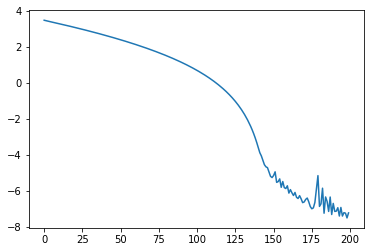

In [ ]:
plt.plot(losses)

In [ ]:
list(k.parameters())

[Parameter containing:
 tensor([[1.3400]], requires_grad=True),
 Parameter containing:
 tensor([0.4287], requires_grad=True),
 Parameter containing:
 tensor([[0.1471]], requires_grad=True),
 Parameter containing:
 tensor([[0.1456]], requires_grad=True),
 Parameter containing:
 tensor([-0.4134], requires_grad=True),
 Parameter containing:
 tensor([[0.0269]], requires_grad=True),
 Parameter containing:
 tensor([0.4979], requires_grad=True),
 Parameter containing:
 tensor([[0.1378]], requires_grad=True)]

## Other

### Testing

#### Negative covariances

In [ ]:
k_ncov = torch.load("broken_predictions.pickle")

In [ ]:
k_ncov

Kalman Filter
        N dim obs: 3, N dim state: 3

In [ ]:
X_ncov = torch.tensor([[-1.0436,  0.3381, -0.9480],
         [-1.0196,  0.0654, -1.0244],
         [ 0.1634, -4.0259,  0.0098],
         [ 2.1246, -7.0855,  2.5321],
         [-0.9851,  0.1255, -0.9227],
         [-0.9705,  0.0442, -0.9466],
         [-0.9575, -0.1892, -0.9410],
         [-1.0009, -0.3096, -0.9664],
         [-1.0515, -0.3703, -1.0022],
         [-1.0888, -0.4806, -1.1086]])

In [ ]:
k_ncov.smooth(X_ncov)

NameError: name 'check_posdef' is not defined

make a `pykalman` model using the same parameters

In [ ]:
pyk_ncov = pykalman.standard.KalmanFilter(

    transition_matrices=k_ncov.transition_matrices.detach().numpy(),
    transition_covariance=k_ncov.transition_cov.detach().numpy(),
    observation_matrices=k_ncov.obs_matrices.detach().numpy(),
    observation_covariance=k_ncov.obs_cov.detach().numpy(),
    initial_state_mean=k_ncov.initial_state_mean.detach().numpy(),
    initial_state_covariance=k_ncov.initial_state_cov.detach().numpy()
    
    
)

In [ ]:
pyk_ncov.smooth(X_ncov.numpy())

In [ ]:
display_as_row(k_ncov.get_info())

In [ ]:
k_ncov.smooth(X_ncov)

### Compare Statsmodels

In [ ]:
import statsmodels.api as sm
import statsmodels

In [ ]:
sm_kf = statsmodels.tsa.statespace.kalman_filter.KalmanFilter(
    k_endog = 3,
    k_states = 3,
    initialization = 'known',
    initial_state = pyk_ncov.initial_state_mean,
    initial_state_cov = pyk_ncov.initial_state_covariance,
    design = pyk_ncov.observation_matrices,
    obs_cov = pyk_ncov.observation_covariance,
    transition = pyk_ncov.transition_matrices,
    state_cov = pyk_ncov.transition_covariance)

In [ ]:
sm_kf.bind(X_ncov.detach().numpy())

In [ ]:
sm_pred = sm_kf.filter() 

In [ ]:
sm_pred.predicted_state.shape

In [ ]:
sm_pred.predicted_state_cov.shape

In [ ]:
mean = MultivariateNormal(torch.tensor(sm_pred.predicted_state[:, 0]), torch.tensor(sm_pred.predicted_state_cov[:, :, 0]))

In [ ]:
sm_kf.loglikeobs()

## Export

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()